# Représenter le niveau de bruit des établissements dans le referentiel structures

## A. charger les donnés

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/2022-06-aurehal-struct-noise-level-per-institution.csv")

In [3]:
print(f"nb d'étab. dans données {len(df)}")
df.info()

nb d'étab. dans données 146
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  146 non-null    int64  
 1   code                146 non-null    object 
 2   name                146 non-null    object 
 3   url                 146 non-null    object 
 4   structId            146 non-null    float64
 5   structId_name       76 non-null     object 
 6   nb_struct           146 non-null    int64  
 7   nb_struct_incoming  146 non-null    int64  
 8   noise               146 non-null    float64
dtypes: float64(2), int64(3), object(4)
memory usage: 10.4+ KB


In [4]:
# retrait de la colonne structId_name car plus a jour après le nettoyage manuel
del df["structId_name"]

## B. Préparer les données pour le graphique

In [5]:
# une colonne clean, opposée de noise, pour valoriser les établissements ayant le moins de bruit
df["clean"] = 1 - df["noise"]

In [6]:
# une colonne noice_pct pour lecture du pourcentage
df["noise_pct"] = round(df["nb_struct_incoming"] * 100 / df["nb_struct"], 0)

In [7]:
# plus de lisibilité : réduire aux étabs avec plus de n structures
df = df[ df["nb_struct"] > 4].copy()

 ### B1. premier matching établissement - propreté

In [8]:
## creer un dictionnaire {etab : value}
# clean ou noise as value selon ce qu'on veut valoriser
etab_freq = df.set_index("code").to_dict()["clean"]

###  B2. deuxième matching établissement établissement - `nb_struct_incoming`
but : représenter le nb de struct incoming à une éch. de couleur
faire correspondre une grandeur à une ech. de couleur (cf. [stackoverflow exemple](https://stackoverflow.com/questions/47398081/how-do-i-map-df-column-values-to-hex-color-in-one-go))

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [10]:
## test_a 
## générer les couleurs aux hasards
import random
def random_color():
    return "#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
#df['color']  = df.apply(lambda x : random_color(), axis = 1)

In [11]:
second_scale = "nb_struct_incoming" # possibilité de repr une autre dimenion (eg. nb struct total ou nb publication...)
df[second_scale].describe()

count    135.000000
mean      46.437037
std      131.120806
min        0.000000
25%        1.000000
50%        8.000000
75%       27.500000
max      999.000000
Name: nb_struct_incoming, dtype: float64

In [12]:
## test_b
## mode automatique avec colormap de matplotlib
## pas assez de variations dans les couleurs

# paramétrer le mapping, min max
norm = matplotlib.colors.Normalize(
    vmin = df[second_scale].min(), 
    vmax = df[second_scale].max(),
    clip=True
)

# précise le colormap à utiliser (cf. https://matplotlib.org/stable/tutorials/colors/colormaps.html)
# different colormap bone_r viridis spring
mapper = plt.cm.ScalarMappable( norm = norm, cmap = plt.cm.spring)
# affecter les couleurs à la df
#df['color'] = df.apply(lambda x: mcolors.to_hex( mapper.to_rgba(x[second_scale])), axis = 1)

In [13]:
## test_c 
## faire le matching à la main
## couleur reprise de la colormap cool de mlt https://matplotlib.org/stable/tutorials/colors/colormaps.html#classes-of-colormaps
df.loc[ df[second_scale]> 700 , "color"] = "#fe00ff" # pink
df.loc[ (df[second_scale] > 100) & (df[second_scale] < 700), "color"] = "#cd31ff"
df.loc[ (df[second_scale] > 0) & (df[second_scale] < 100), "color"] = "#936cff"
df.loc[ df[second_scale] == 0, "color"] = "#59a5ff" #bleu

In [14]:
#create a dict matching color to portail code
# color -> list portail code
color_to_words = df.groupby('color')['code'].agg(list).to_dict()
print("nb de couleur utilisées", len(color_to_words.keys()) )

nb de couleur utilisées 4


## C. Nuage de mots-clés

avec deux dimensions : 
* taille des noms des portails ---> propreté
* nb struct incoming ---> couleur des noms des portails (cf [stackoverflow exemple](https://stackoverflow.com/questions/70883110/python-wordcloud-how-to-make-the-word-colour-based-on-a-data-column))

In [15]:
from wordcloud import WordCloud

In [16]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

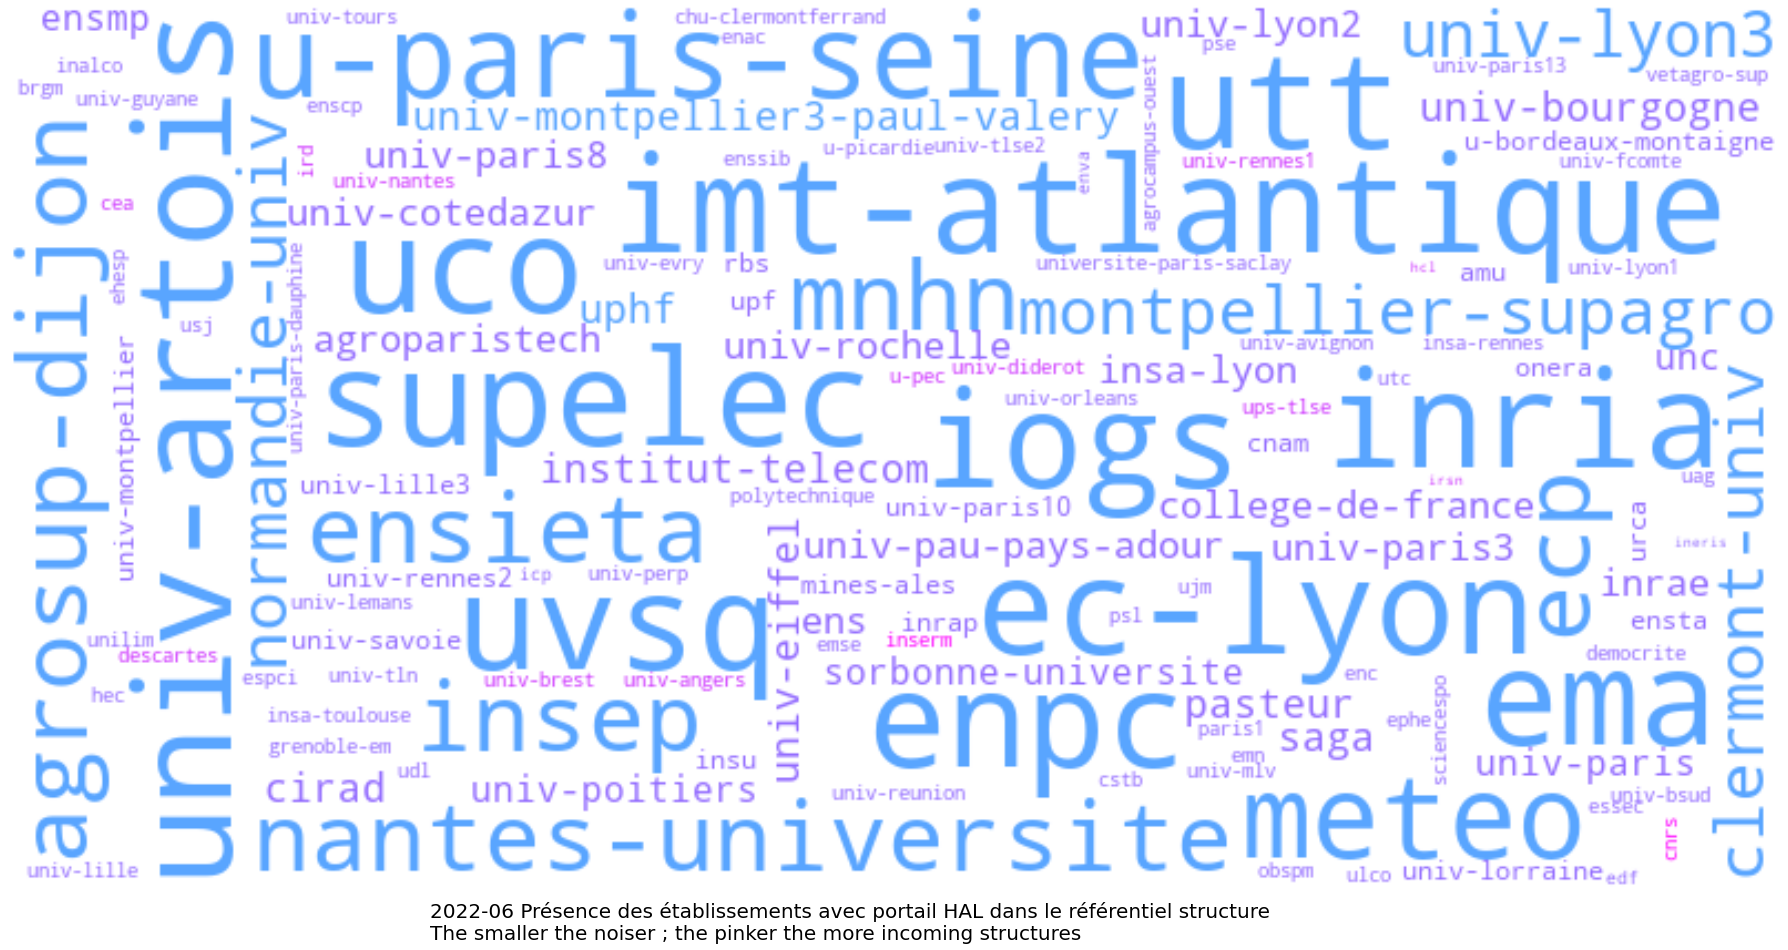

In [24]:
wordcloud = WordCloud(background_color="white", width=800, height=400, min_font_size = 6, max_font_size = 60)
# generer le wordcloud à partir de frequence
wordcloud.generate_from_frequencies(etab_freq)

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Creating word_cloud with text as argument in .generate() method
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func = grouped_color_func)

# Display the generated Word Cloud
plt.figure(figsize=(25,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")

## memo bien préciser la date dans plt.text
plt.text(190, 420, f"2022-06 Présence des établissements avec portail HAL dans le référentiel structure\nThe smaller the noiser ; the pinker the more incoming structures",
         size = 20, color = "black")

plt.savefig("../img/aurehal-struct-cleaniest-institutions.png", dpi = 200, bbox_inches='tight', pad_inches= 0, transparent= False)

---
## Z. afficher les données en tableau

In [18]:
#afficher toutes les rows de la df
pd.set_option('display.max_rows', None) 

In [19]:
# trier & afficher
df.sort_values("clean", ascending = False , inplace = True, ignore_index = True)
df

,id,code,name,url,structId,nb_struct,nb_struct_incoming,noise,clean,noise_pct,color
0,6477,u-paris-seine,CY Cergy Paris Université,https://hal-cyu.archives-ouvertes.fr/,1003413.0,37,0,0.000000,1.000000,0.0,#59a5ff
1,66,iogs,Institut d'Optique Graduate School,https://hal-iogs.archives-ouvertes.fr,300036.0,7,0,0.000000,1.000000,0.0,#59a5ff
2,6442,uphf,Université Polytechnique des Hauts-de-France,https://hal-uphf.archives-ouvertes.fr,1001263.0,21,0,0.000000,1.000000,0.0,#59a5ff
3,34,mnhn,MNHN - Muséum national d'Histoire naturelle,https://hal-mnhn.archives-ouvertes.fr,7512.0,141,0,0.000000,1.000000,0.0,#59a5ff
4,8393,univ-montpellier3-paul-valery,Université Paul Valéry Montpellier 3,https://hal-univ-montpellier3-paul-valery.arch...,42812.0,84,0,0.000000,1.000000,0.0,#59a5ff
5,8897,uco,Université Catholique de l'Ouest,https://hal-uco.archives-ouvertes.fr,300844.0,22,0,0.000000,1.000000,0.0,#59a5ff
6,9610,ec-lyon,École Centrale de Lyon,https://hal-ec-lyon.archives-ouvertes.fr,126765.0,25,0,0.000000,1.000000,0.0,#59a5ff
7,4926,montpellier-supagro,Montpellier SupAgro,https://hal-montpellier-supagro.archives-ouver...,1090073.0,25,0,0.000000,1.000000,0.0,#59a5ff
8,69,enpc,Ecole des Ponts ParisTech,https://hal-enpc.archives-ouvertes.fr,301545.0,62,0,0.000000,1.000000,0.0,#59a5ff
9,4638,insep,"Insep - Institut national du sport, de l'exper...",https://hal-insep.archives-ouvertes.fr,441096.0,5,0,0.000000,1.000000,0.0,#59a5ff


In [26]:
df["noise_pct"].describe()

count    135.000000
mean      21.548148
std       22.800144
min        0.000000
25%        2.000000
50%       14.000000
75%       34.000000
max       89.000000
Name: noise_pct, dtype: float64